In [1]:
from glob import glob
from tqdm import tqdm
from time import time
import logging
import os

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import random_split

from model import Unet
from dataset import ImageDataset

In [110]:
BATCH_SIZE = 16
EPOCHS = 1000
LR = 0.0001

In [3]:
checkpoints_path = '/home/workspace/iot_ai_model/check_points/unet'

In [4]:
data_path = '/home/workspace/iot_ai_model/dataset/supervisely_person'

In [5]:
paths = glob(os.path.join(data_path,"**/*.png"))

In [6]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(message)s')
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

In [7]:
dataset = ImageDataset(data_path)

images Loading: 2667it [01:13, 36.33it/s] 
masks Loading: 2667it [00:38, 68.44it/s] 


In [8]:
dataset_size = len(dataset)
trn_size = int(dataset_size * 0.8)
val_size = dataset_size - trn_size
trn_ds, val_ds = random_split(dataset, [trn_size, val_size])
trn_loader = torch.utils.data.DataLoader(trn_ds, batch_size= BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size= BATCH_SIZE, shuffle=False)
logger.info(f'trn: {len(trn_ds)}, val: {len(val_ds)}')    

2022-10-02 11:45:49,056 - trn: 2133, val: 534


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f'Load on {device}')

2022-10-02 11:45:49,816 - Load on cuda


In [10]:
model = Unet().to(device)
params_cnt = sum(p.numel() for p in model.parameters() if p.requires_grad)
logger.info(f'loaded model (params {params_cnt})')

2022-10-02 11:45:52,511 - loaded model (params 22795143)


In [107]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = LR)

In [108]:
def fit(model, dataloader, criterion, optimizer, device, half = False):
    loss = .0
    acc = .0
    correct = 0
    start_time = time()
    
    progress = tqdm(dataloader)
    for path, data, target in progress:
        data = data.to(device).type(torch.float32)
        target = target.to(device).type(torch.float32)
        
        if half :
            data = data.half()
        
        output = model(data)
        output = output.squeeze(dim=1)
        loss = criterion(output, target)
        
        if model.training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        loss += loss
        
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        correct += output.eq(target).int().sum()

    acc = (correct/len(dataloader.dataset))
    loss = loss/len(dataloader.dataset)
    logger.info("{}, duration:{:6.1f}s, acc:{:.4f}, loss:{:.4f}".format(('trn' if model.training else 'val'), 
                                                                         time()-start_time, 
                                                                         acc, 
                                                                         loss ))
    return float(loss), float(acc)

100%|██████████| 134/134 [00:55<00:00,  2.42it/s]
2022-10-03 07:12:38,580 - trn, duration:  55.4s, acc:195620.6250, loss:0.0000
100%|██████████| 34/34 [00:04<00:00,  7.56it/s]
2022-10-03 07:12:43,122 - val, duration:   4.5s, acc:183807.0469, loss:0.0048


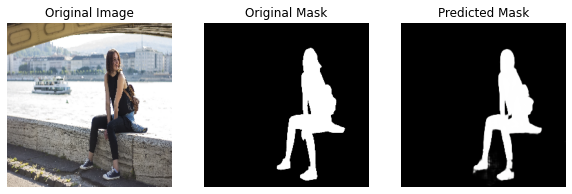

2022-10-03 07:12:43,249 - epoch 991
100%|██████████| 134/134 [00:55<00:00,  2.42it/s]
2022-10-03 07:13:38,795 - trn, duration:  55.5s, acc:195626.3125, loss:0.0000
100%|██████████| 34/34 [00:04<00:00,  7.58it/s]
2022-10-03 07:13:43,327 - val, duration:   4.5s, acc:183819.4219, loss:0.0051


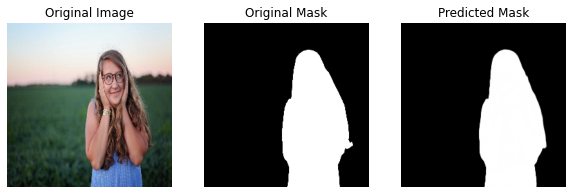

2022-10-03 07:13:43,456 - epoch 992
100%|██████████| 134/134 [00:55<00:00,  2.42it/s]
2022-10-03 07:14:38,842 - trn, duration:  55.3s, acc:195629.2344, loss:0.0000
100%|██████████| 34/34 [00:04<00:00,  7.54it/s]
2022-10-03 07:14:43,397 - val, duration:   4.5s, acc:183716.9531, loss:0.0049


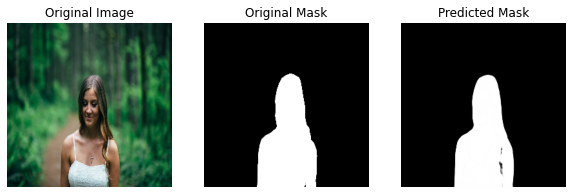

2022-10-03 07:14:43,527 - epoch 993
100%|██████████| 134/134 [00:55<00:00,  2.42it/s]
2022-10-03 07:15:39,001 - trn, duration:  55.4s, acc:195630.6562, loss:0.0000
100%|██████████| 34/34 [00:04<00:00,  7.56it/s]
2022-10-03 07:15:43,544 - val, duration:   4.5s, acc:183868.5938, loss:0.0049


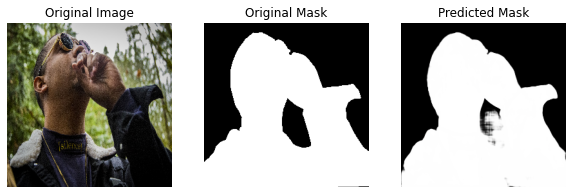

2022-10-03 07:15:43,674 - epoch 994
100%|██████████| 134/134 [00:55<00:00,  2.42it/s]
2022-10-03 07:16:39,085 - trn, duration:  55.3s, acc:195632.6719, loss:0.0000
100%|██████████| 34/34 [00:04<00:00,  7.57it/s]
2022-10-03 07:16:43,620 - val, duration:   4.5s, acc:183819.7969, loss:0.0053


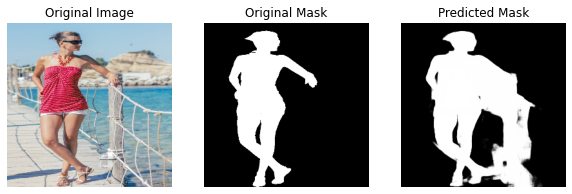

2022-10-03 07:16:43,750 - epoch 995
100%|██████████| 134/134 [00:55<00:00,  2.42it/s]
2022-10-03 07:17:39,222 - trn, duration:  55.4s, acc:195636.1719, loss:0.0000
100%|██████████| 34/34 [00:04<00:00,  7.55it/s]
2022-10-03 07:17:43,768 - val, duration:   4.5s, acc:183673.9844, loss:0.0062


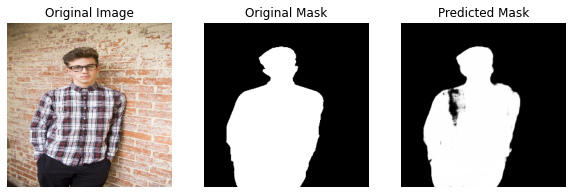

2022-10-03 07:17:43,897 - epoch 996
100%|██████████| 134/134 [00:55<00:00,  2.42it/s]
2022-10-03 07:18:39,315 - trn, duration:  55.3s, acc:195636.8906, loss:0.0000
100%|██████████| 34/34 [00:04<00:00,  7.58it/s]
2022-10-03 07:18:43,847 - val, duration:   4.5s, acc:183878.5156, loss:0.0051


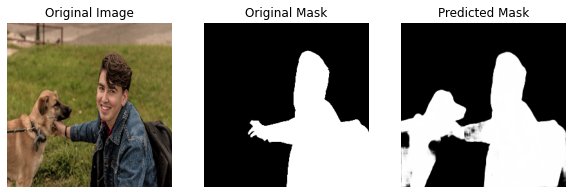

2022-10-03 07:18:43,977 - epoch 997
100%|██████████| 134/134 [00:55<00:00,  2.42it/s]
2022-10-03 07:19:39,410 - trn, duration:  55.4s, acc:195638.5312, loss:0.0000
100%|██████████| 34/34 [00:04<00:00,  7.54it/s]
2022-10-03 07:19:43,961 - val, duration:   4.5s, acc:183884.7656, loss:0.0054


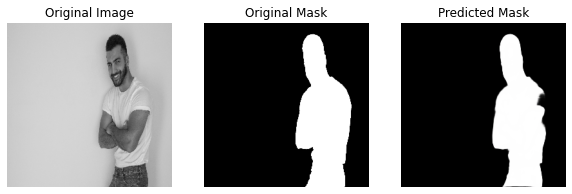

2022-10-03 07:19:44,087 - epoch 998
100%|██████████| 134/134 [00:55<00:00,  2.42it/s]
2022-10-03 07:20:39,609 - trn, duration:  55.4s, acc:195639.4531, loss:0.0000
100%|██████████| 34/34 [00:04<00:00,  7.59it/s]
2022-10-03 07:20:44,135 - val, duration:   4.5s, acc:183880.5938, loss:0.0056


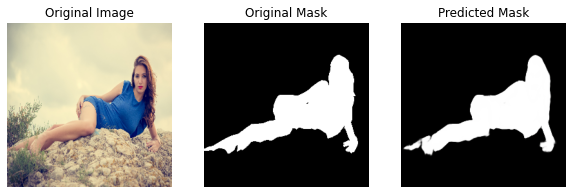

2022-10-03 07:20:44,355 - epoch 999
100%|██████████| 134/134 [00:55<00:00,  2.42it/s]
2022-10-03 07:21:39,856 - trn, duration:  55.4s, acc:195642.0312, loss:0.0000
100%|██████████| 34/34 [00:04<00:00,  7.54it/s]
2022-10-03 07:21:44,410 - val, duration:   4.5s, acc:183851.8906, loss:0.0057


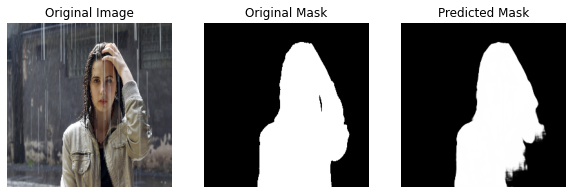

2022-10-03 07:21:44,538 - epoch 1000
100%|██████████| 134/134 [00:55<00:00,  2.42it/s]
2022-10-03 07:22:39,915 - trn, duration:  55.3s, acc:195641.6094, loss:0.0000
100%|██████████| 34/34 [00:04<00:00,  7.57it/s]
2022-10-03 07:22:44,452 - val, duration:   4.5s, acc:183891.3750, loss:0.0053


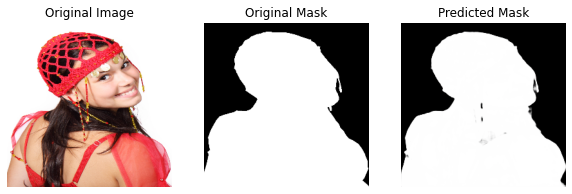

In [111]:
trn_loss = []
trn_acc = []
val_loss = []
val_acc = []

half = False

min_loss = 99999.
early_count = 0
for epoch in range(1, EPOCHS+1):
    logger.info(f'epoch {epoch}')

    model.train()
    loss, acc = fit(model, trn_loader, criterion, optimizer, device, half=half)

    trn_loss.append(loss)
    trn_acc.append(acc)

    model.eval()
    with torch.no_grad():
        loss, acc = fit(model, val_loader, criterion, optimizer, device, half=half)

        # if loss >= min_loss:
        #     early_count += 1
        #     if early_count >= early_stopping:
        #         break
        # else:
        #     min_loss = loss
        #     early_count = 0

        if len(val_loss) > 0 and min(val_loss) > loss:
            torch.save(model.state_dict(), f"{checkpoints_path}/model_state_dict_{epoch}_best.pt")

        val_loss.append(loss)
    
    show_predictions(model, val_ds)

torch.save(model.state_dict(), f"{checkpoints_path}/model_state_dict_{epoch}.pt")

In [121]:
with open('/home/workspace/iot_ai_model/dataset/supervisely_person/test_data_list.txt', 'w') as f:
    for idx, (filename, _, _) in enumerate(val_ds):
        f.write('{},{}\n'.format(filename.replace('/home/workspace/iot_ai_model/dataset/supervisely_person/', ''), val_ds.dataset.mask_path[idx]))

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [64]:
def get_random_data(dataset):
    id = np.random.randint(len(dataset))
    path, image, mask = dataset[id]
    return image, mask

In [65]:
def convert_tensor_to_img(tensor):
    img = tensor.cpu().detach().numpy()
    img = np.transpose(img, (1,2,0))
    return img
    
def convert_img_to_tensor(img, device = 'cpu'):
    return torch.tensor(img.reshape(1,3,256,256)).to(device)

In [66]:
def show_image(image, alpha=1, title=None):
    plt.imshow(image, alpha=alpha)
    plt.title(title)
    plt.axis('off')

In [103]:
def show_predictions(model, dataset, n_images=1):
    for i in range(n_images):
        plt.figure(figsize=(10,8))
        
        img, mask = get_random_data(dataset)
        tensor = convert_img_to_tensor(img, device= device)
        pred_mask = model(tensor)
        
        plt.subplot(1,3,1)
        img = np.transpose(img, (1,2,0))
        show_image(img, title='Original Image')
        
        plt.subplot(1,3,2)
        mask = np.transpose(mask, (1,2,0))
        show_image(mask, title='Original Mask')
        
        plt.subplot(1,3,3)
        pred_img = convert_tensor_to_img(pred_mask[0])
        show_image(pred_img, title='Predicted Mask')
        
        plt.show()

In [1]:
import numpy as np

In [15]:
a = np.array([[3,123],[124,123],[124,123]]).reshape(-1)

In [16]:
a[a > 5] = 1

In [17]:
a

array([3, 1, 1, 1, 1, 1])

In [18]:
from PIL import Image

In [19]:
p = '/home/workspace/iot_ai_model/dataset/supervisely_person/images/ds9_pexels-photo-884417.png'

In [21]:
image = np.asarray(Image.open(p).resize((256,256)))

In [22]:
image.shape

(256, 256, 3)